In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries to import

In [2]:
import scipy.io
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

#Signal Processing Class

In [3]:
class SP:
    def __init__(self, Fs, Bw, fault_frequencies, visual):
        self.Fs = Fs
        self.Bw = Bw
        self.fault_frequencies = fault_frequencies
        self.visual = visual

    def butter_bandpass(self, data, lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        y = lfilter(b, a, data)
        return y

    def forward(self, x):
        N = len(x)
        f_ax = np.linspace(0, Fs / 2, N // 2)

        x_filtered = self.butter_bandpass(x, self.Bw[0], self.Bw[1], self.Fs, order=5)

        analytic_signal = scipy.signal.hilbert(x_filtered)
        amplitude_envelope = np.abs(analytic_signal)
        Env_spec = np.abs(scipy.fft.rfft(amplitude_envelope))[:-1]

        indexes = np.zeros(len(self.fault_frequencies), dtype=int)

        for k in range(len(self.fault_frequencies)):
            indexes[k] = np.argmin(np.abs(f_ax - self.fault_frequencies[k]))

        if (self.visual == True):
          plt.figure()
          plt.plot(f_ax, Env_spec)
          plt.xlim(0, 500)
          plt.xlabel('Frequency (Hz)')
          plt.ylabel('Envelope Spectrum')
          plt.title('Envelope Spectrum')
          plt.show()

        if (1 / len(self.fault_frequencies)) * np.sum(Env_spec[indexes]) > np.mean(Env_spec) + 5 * np.std(Env_spec):
            return 1
        else:
            return 0

#Main

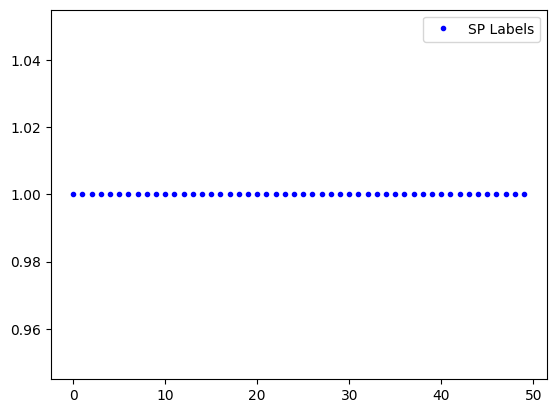

In [8]:
matfile = 'simple_faulty_dataset.mat'
directory='/content/drive/MyDrive/Colab Notebooks/Differentiable SP/'+matfile
mat_data = scipy.io.loadmat(directory)

Fs = mat_data['Fs'][0, 0]
x = mat_data['data'][0]
step = 10 * mat_data['Event'][0, 0]
nb_seg = len(x) // step

nH = 7
fault_frequencies = 60 * np.arange(1, nH + 1)
Bw = [2500, 3000]
visual = False

sp = SP(Fs, Bw, fault_frequencies,visual)

sp_labels = np.zeros(nb_seg)

for i in range(nb_seg):
    seg = x[i * step: (i + 1) * step]
    H = sp.forward(seg)
    sp_labels[i] = H

plt.figure()
plt.plot(sp_labels, '.b', linewidth=1.5)
plt.legend(['SP Labels'])
plt.show()

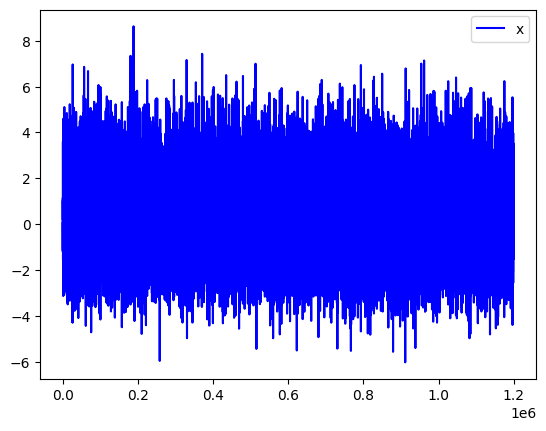

In [5]:
plt.figure()
plt.plot(x, 'b', linewidth=1.5)
plt.legend(['x'])
plt.show()